# A first look convnet



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from fastai import *
from fastai.vision import *

from glob import glob

%matplotlib inline


In [0]:
%cd /content/drive/My\ Drive/alfalfa-convnets

PATH = os.path.abspath('.')

/content/drive/My Drive/alfalfa-convnets


# Making the toy catalog

In [0]:
df = pd.read_csv(f'{PATH}/data/a100.code12.tab1.180315.csv')
df.sample(5)

,AGCNr,Name,RAdeg_HI,DECdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,sigW,W20,HIflux,sigflux,SNR,RMS,Dist,sigDist,logMH,siglogMH,HIcode
19280,742698,........,195.79375,19.98722,195.80292,19.97778,6710,72,9,215,0.34,0.04,5.2,1.70,100.0,2.2,8.90,0.07,2
30289,337075,........,351.61874,3.16444,351.60123,3.15972,3621,73,14,392,3.13,0.08,32.2,2.52,51.8,2.2,9.30,0.06,1
22396,241415,018-067.,212.73251,1.03889,212.74001,1.03583,7607,312,4,77,2.84,0.13,11.8,3.05,112.4,2.3,9.93,0.05,1
996,101819,........,7.61333,26.64611,7.61167,26.64250,9665,261,5,278,2.59,0.09,16.4,2.18,133.4,2.3,10.04,0.05,1
10258,190664,064-030.,150.23875,11.17917,150.23749,11.18222,10880,40,6,95,1.75,0.05,28.0,2.14,160.2,2.2,10.02,0.05,1


In [0]:
ids = np.array([os.path.basename(fn).strip('.jpg') for fn in glob(f'{PATH}/images-OC/*.jpg')], dtype=int)
print(ids[:5])

[333400 334491 332942 333116 332961]


In [0]:
len(ids)

30305

In [0]:
# isolate those that have imaging (AGC ids match the JPG files) && those with HIcode == 1
df = df[df.AGCNr.isin(ids) & (df.HIcode == 1)]

# save out two-column table of names, HI mass
train_label_csv = f'{PATH}/data/a.100-OC-cutouts.csv'

table = df[['AGCNr', 'logMH']]
table.to_csv(train_label_csv, index=False)

# Compile DataBunch

In [0]:
df = pd.read_csv(train_label_csv)
df.sample(5)

,AGCNr,logMH
21359,323444,9.65
19451,252522,8.72
20653,268019,9.10
12798,220230,8.45
15124,725478,9.72


In [0]:
bs = 128
sz = 224

In [0]:
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2)
                .label_from_df(cols='logMH',  label_cls=FloatList)
      )

In [0]:
data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize())

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f4e48a0e438>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 677, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 659, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


In [0]:
data.show_batch(3, figsize=(12, 12))

KeyboardInterrupt: ignored

# Train simple convnet

In [0]:
# defaults.device = torch.device('cpu')

In [0]:
class SimpleCNN(nn.Module):
    def __init__(self, pretrained=False):                  # pretrained kw is hardcoded into create_cnn
        super(SimpleCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(32*32*32, 1)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
# for some stupid reason this isn't working in my current version of fastai
def root_mean_squared_error(pred:Tensor, targ:Tensor)->Rank0Tensor:
    "Root mean squared error between `pred` and `targ`."
    return torch.sqrt(F.mse_loss(pred.flatten(), targ.flatten()))

In [0]:
learn = cnn_learner(data, base_arch=SimpleCNN, pretrained=False, loss_func=root_mean_squared_error)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


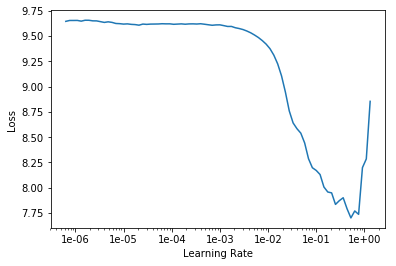

In [0]:
learn.lr_find(end_lr=10)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(100, slice(1e-3, 5e-2))

epoch,train_loss,valid_loss,time
0,8.297212,7.141116,00:36
1,5.158309,1.478165,00:37
2,3.338672,0.992192,00:36
3,2.345920,0.922191,00:36
4,1.783657,0.662831,00:36
5,1.417059,0.677858,00:36
6,1.190950,0.638629,00:36
7,1.057364,0.648836,00:36
8,0.963056,0.595918,00:36
9,0.923947,0.718894,00:36


(0, 2)

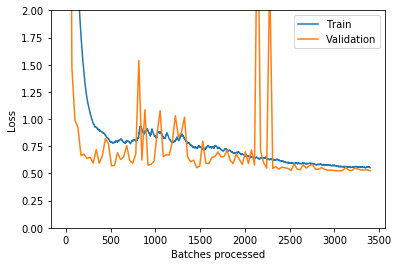

In [0]:
learn.recorder.plot_losses()
plt.ylim(0, 2)

In [0]:
learn.save('a.100-resnet18_init.higher-lr')

# Visualize

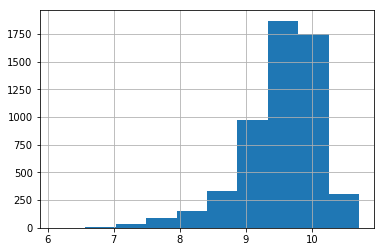

In [0]:
df.logMH.hist()

In [0]:
HI_pred, HI_true = learn.TTA()

# store results, along with AGC identifier, in new DataFrame
results = pd.DataFrame({'HI_true': HI_true.squeeze(), 'HI_pred': HI_pred.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)

results.sample(3)

,HI_true,HI_pred
AGCNr,,
7510,8.32,9.379498
191796,9.05,9.148367
170220,10.02,9.655348


In [0]:
# how well did we do?
root_mean_squared_error(HI_pred, HI_true)

tensor(0.5146)

In [0]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def offset_image(objID, zoom=0.1):
    return OffsetImage(image2np(open_image(f'{PATH}/images-OC/{objID}.jpg').data), zoom=zoom)

def plot_results(results, show_images=True):
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.scatter('HI_true', 'HI_pred', data=results, c='black')

    if show_images:
        artists = []
        for objID, [Z_true, Z_pred] in results.sample(100).iterrows():
            ab = AnnotationBbox(offset_image(objID, zoom=0.4), (Z_true, Z_pred), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
            
    # plot 1:1 line
    plt.plot([6, 12], [6, 12], c='C3', ls='--', lw='10')

    ax.set_xlim(7, 11)
    ax.set_ylim(7, 11)
    ax.set_xlabel('True log HI')
    ax.set_ylabel('Pred log HI')



So we got 0.5 dex accuracy in logarithmic HI mass using 400 galaxies. Note that we've taken cutouts at the nearest optical positions! We may want to try doing the same at the ALFALFA positions...

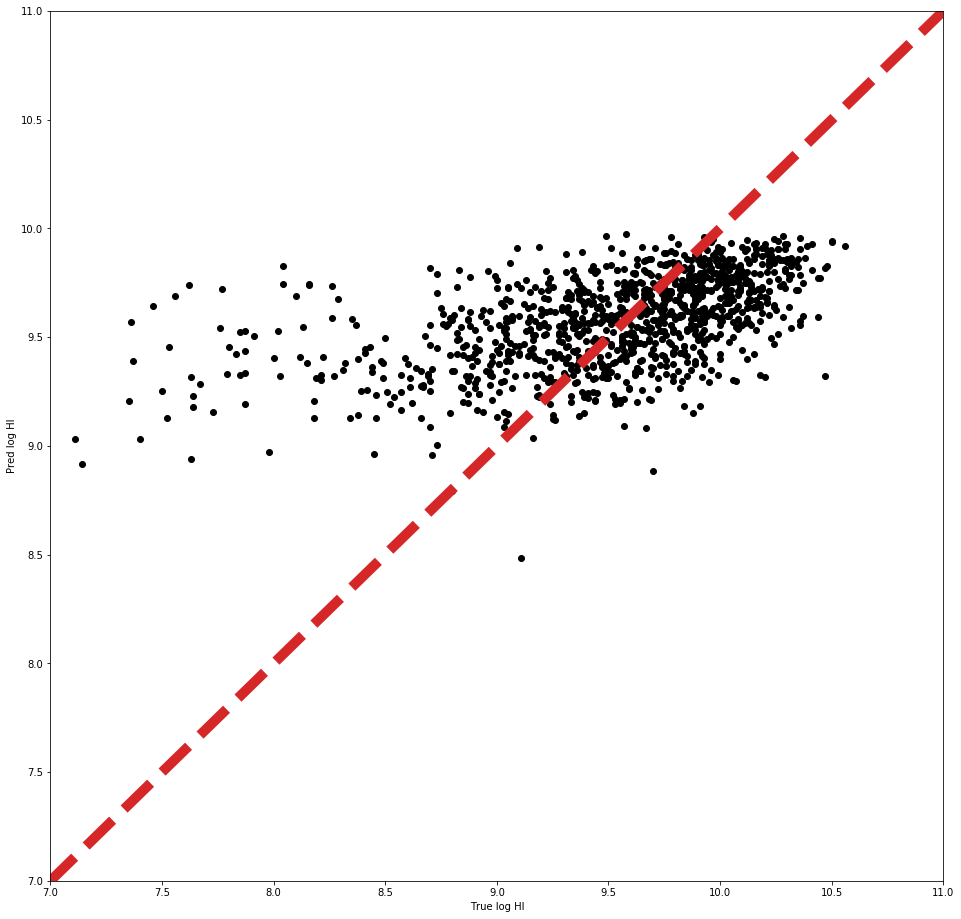

In [0]:
plot_results(results, show_images=False)

(8.5, 10.3)

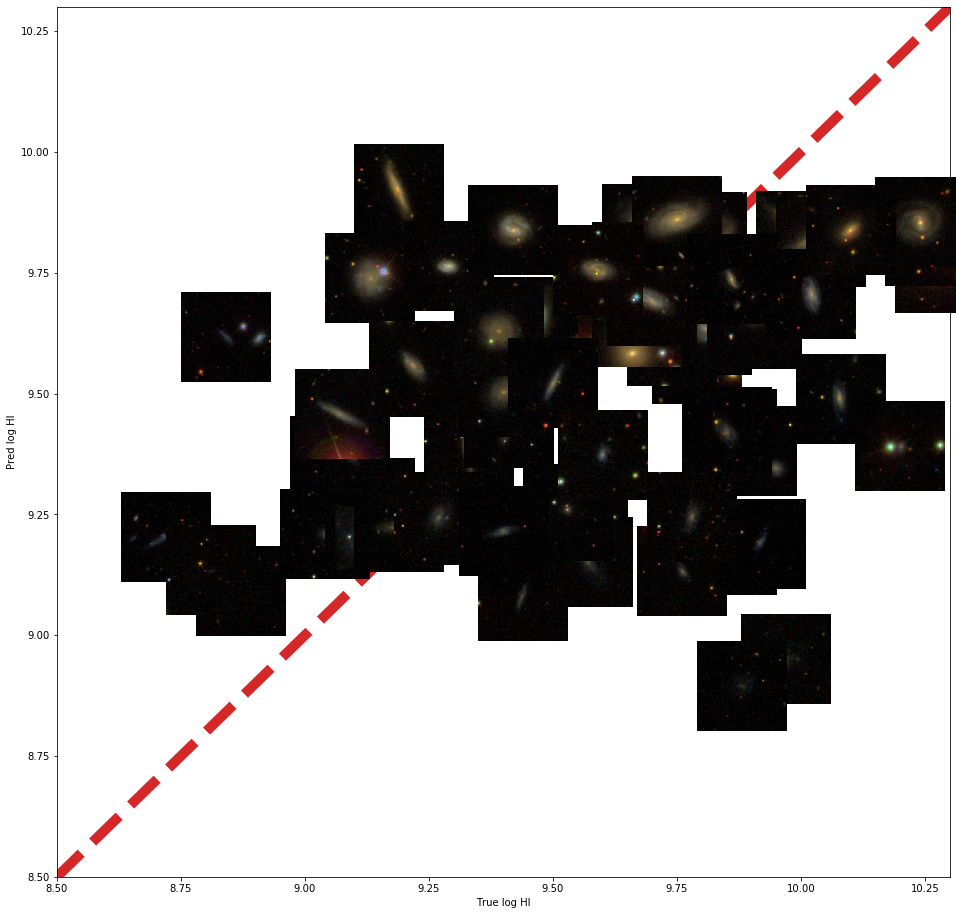

In [0]:
plot_results(results)
plt.xlim(8.5, 10.3)
plt.ylim(8.5, 10.3)

# Results

We're not doing a good job because of pointing errors, HI flux limits (rather than stellar mass or volume limits), and the fact that f_gas is more of an intrinsic quantity than total HI mass.

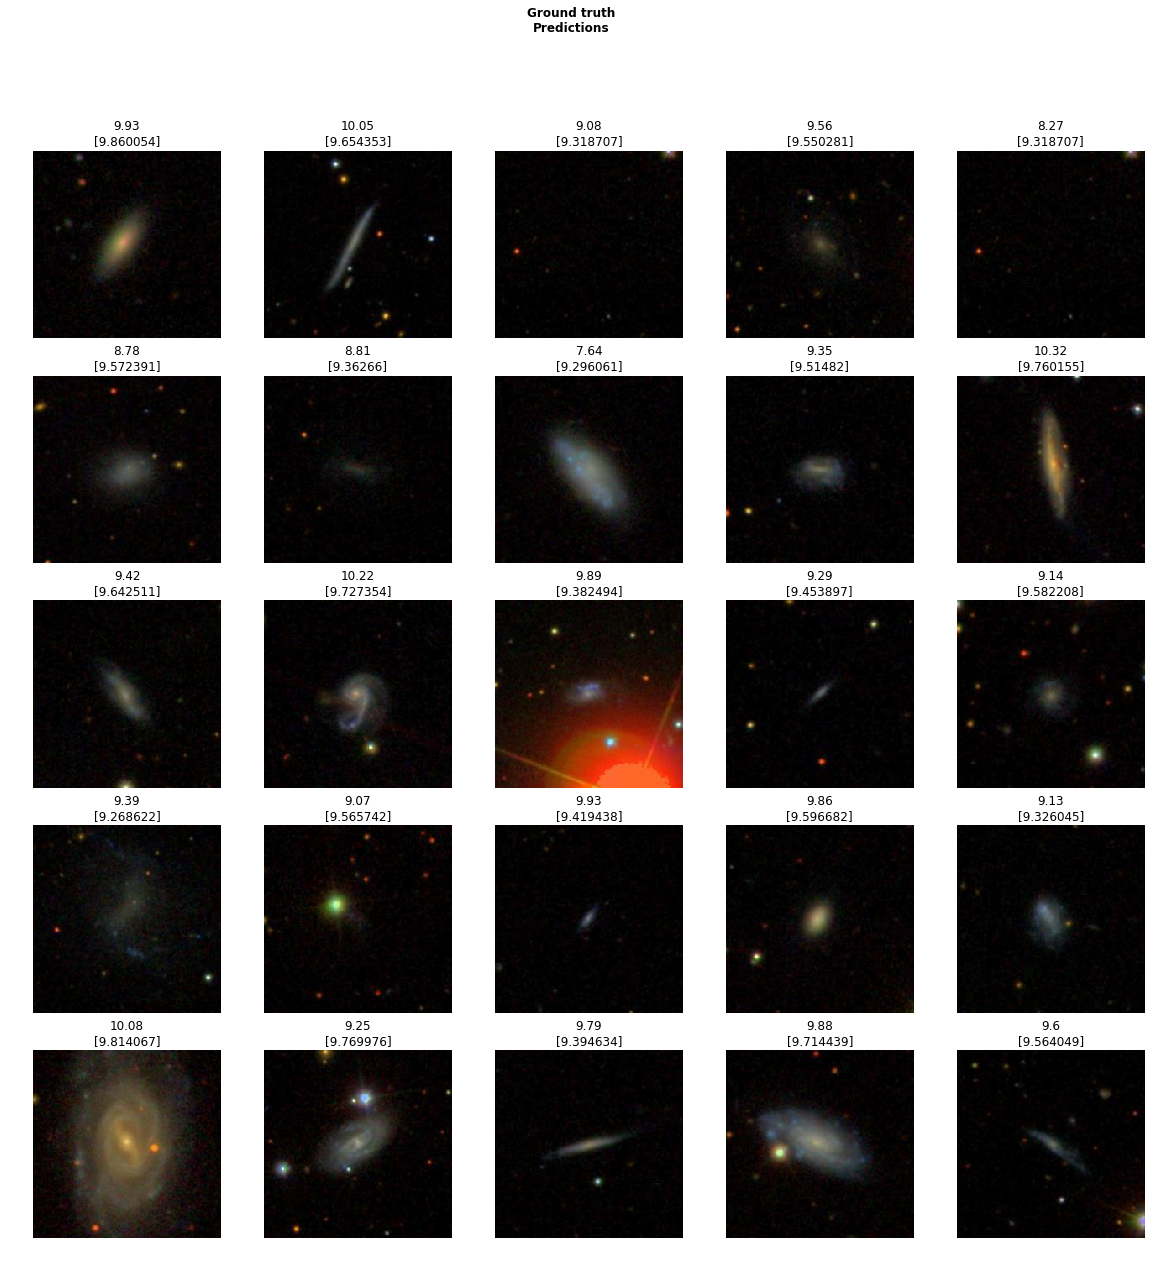

In [0]:
learn.show_results()

# Making a SDSS-crossmatched alpha.40 catalog

In [0]:
df = pd.read_csv(f'{PATH}/data/a40.datafile3.csv')
display(df.sample(5))
display(df.shape)

,AGCNr,HIcode,OCcode,PhotoObjID,SpectObjID,rmodelmag,uminusr,z_sdss,z_err
3171,203873,1,I,587728881413587109,1.617915e+17,15.80,1.49,0.03199,0.00008
3208,205130,1,I,587745538908749961,7.286899e+17,16.92,1.46,0.03444,0.00008
5354,6668,1,I,587734893288095841,3.450335e+17,12.58,2.58,0.02163,0.00019
836,171778,1,I,588013383793246652,2.417302e+17,15.48,1.48,0.01548,0.00020
8285,232108,1,I,588017726556733565,5.077320e+17,16.43,1.49,0.02881,0.00011


(12468, 9)

In [0]:
df2 =  pd.read_csv(f'{PATH}/data/a40.datafile1.csv')
display(df2.sample(5))
display(df2.shape)

,AGCNr,Name,RAdeg_HI,Decdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,errW50,HIflux,errflux,SNR,RMS,Dist,logMsun,HIcode,OCcode,NoteFlag
2650,171519,NaN,118.06291,15.77444,118.06458,15.77194,17693,258,5,1.39,0.09,8.1,2.39,255.8,10.33,2,I,*
5025,721954,NaN,152.45250,27.09861,152.44499,27.10500,14531,289,65,1.11,0.10,5.8,2.50,211.8,10.07,2,I,NaN
3138,181493,ADBS,124.28416,24.56639,124.28292,24.56278,2130,61,2,1.38,0.05,17.1,2.29,32.1,8.52,1,T,NaN
1474,113963,NaN,28.82167,30.83306,28.81709,30.83445,7461,118,6,2.24,0.07,19.4,2.37,102.9,9.75,1,O,NaN
12042,240634,076-012,221.02834,9.28056,221.02626,9.28028,9311,72,4,3.85,0.07,39.5,2.54,136.0,10.22,1,I,*


(15855, 18)

In [0]:
# combine both
joined = df.join(df2.set_index('AGCNr'), on='AGCNr', rsuffix='_sdss')
display(joined.sample(5))
display(joined.shape)

,AGCNr,HIcode,OCcode,PhotoObjID,SpectObjID,rmodelmag,uminusr,z_sdss,z_err,Name,RAdeg_HI,Decdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,errW50,HIflux,errflux,SNR,RMS,Dist,logMsun,HIcode_sdss,OCcode_sdss,NoteFlag
7611,233791,1,I,588017990149931108,5.057605e+17,15.33,2.24,0.04744,0.00017,NaN,197.57167,8.75028,197.56209,8.75139,14208,420,26,2.79,0.15,10.5,2.83,207.4,10.45,1,I,*
4811,723412,2,I,587741708880904281,6.239796e+17,17.84,1.72,0.02656,0.00009,NaN,169.77750,26.52972,169.77208,26.53000,7978,99,13,0.37,0.06,3.5,2.33,118.3,9.09,2,I,NaN
5383,215226,1,I,587738569773417030,NaN,18.22,1.13,NaN,NaN,NaN,175.88582,15.04833,175.88541,15.04250,2970,86,12,0.45,0.04,6.6,1.63,45.0,8.33,1,I,NaN
9085,248902,2,I,587742629057790127,7.728817e+17,16.81,1.57,0.02647,0.00008,Holm612b,213.39790,16.12806,213.37708,16.13222,7878,110,80,0.75,0.06,7.2,2.19,115.9,9.38,2,I,*
2255,721420,2,I,587741422179582196,6.450899e+17,17.18,1.44,0.03280,0.00009,NaN,141.15041,25.38778,141.15874,25.39778,9826,102,33,0.78,0.09,5.8,2.97,144.3,9.58,2,I,NaN


(12468, 26)

In [0]:
ids = np.array([os.path.basename(fn).strip('.jpg') for fn in glob(f'{PATH}/images-OC/*.jpg')], dtype=int)

In [0]:
joined.AGCNr.isin(ids).sum(), (joined.OCcode == 'I').sum(), (joined.Vhelio < 15000).sum()

(12457, 11739, 11773)

Note: the first time I did this, I didn't make a (V > 1000 km/s) cut, and so my convnet got very unhappy with extremely nearby systems that spanned the entire field of view!

In [0]:
# again only use confident detections
confident = (joined.AGCNr.isin(ids)) & (joined.OCcode == 'I') & (joined.logMsun.notna())

# also make cz < 15000 km/s cut (plus > 1000 km/s to get rid of extremely close stuff)
velocity_cut = (joined.Vhelio < 15000) & (joined.Vhelio > 1000)

# make a cut here
table = joined[confident & velocity_cut]

table.sample(5)

,AGCNr,HIcode,OCcode,PhotoObjID,SpectObjID,rmodelmag,uminusr,z_sdss,z_err,Name,RAdeg_HI,Decdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,errW50,HIflux,errflux,SNR,RMS,Dist,logMsun,HIcode_sdss,OCcode_sdss,NoteFlag
5630,215214,1,I,587742772947320970,NaN,18.05,1.10,NaN,NaN,NaN,178.25333,16.16444,178.25999,16.17028,6834,202,5,0.82,0.08,5.9,2.16,102.4,9.31,1,I,*
11003,251636,1,I,587736547388686525,5.125173e+17,13.56,1.87,0.03957,0.00010,N5960,234.07542,5.66750,234.07666,5.66528,11877,331,9,1.28,0.10,6.8,2.30,171.7,9.95,1,I,NaN
2477,191273,1,I,587741490362384441,6.464973e+17,14.59,1.78,0.02078,0.00017,122-040,144.63626,23.89611,144.63333,23.89083,6210,222,3,2.61,0.09,16.4,2.38,92.8,9.72,1,I,*
11877,262417,1,I,587736916226867478,4.877444e+17,17.18,1.65,0.03550,0.00008,NaN,245.90793,7.74250,245.90666,7.74111,10642,196,6,1.23,0.09,8.2,2.39,153.0,9.83,1,I,*
3528,205386,2,I,587734862147682531,3.489741e+17,17.64,1.24,0.03680,0.00003,NaN,157.01749,8.24611,157.02249,8.24583,11076,96,14,0.60,0.07,5.6,2.40,163.2,9.58,2,I,NaN


In [0]:
# verify that we have HI masses
table.logMsun.isna().sum(), len(table)

(0, 10863)

In [0]:
# save out two-column table of names, HI mass
train_label_csv = f'{PATH}/data/a.40_SDSS-vol-limited_OC-cutouts.csv'

table = table[['AGCNr', 'logMsun']]
table.to_csv(train_label_csv, index=False)

# Train on volume-limited SDSS-crossmatched sample

In [0]:
bs = 256
sz = 112

In [0]:
train_label_csv = f'{PATH}/data/a.40_SDSS-vol-limited_OC-cutouts.csv'
df = pd.read_csv(train_label_csv)

In [0]:
src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2)
                .label_from_df(cols='logMsun',  label_cls=FloatList)
      )

data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize())

In [0]:
x,y = next(iter(data.valid_ds))

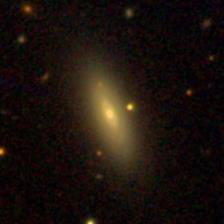

FloatItem 9.89

'/content/drive/My Drive/alfalfa-convnets/images-OC/180420.jpg'

In [0]:
display(data.valid_ds.x[0])
display(data.valid_ds.y[0])
display(data.valid_ds.items[0])

In [0]:
learn = cnn_learner(data, base_arch=models.resnet18, pretrained=True, loss_func=root_mean_squared_error)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 81907053.22it/s]


In [0]:
learn.fit(1, 0.1)

epoch,train_loss,valid_loss,time
0,2.973615,1.821300,12:19


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


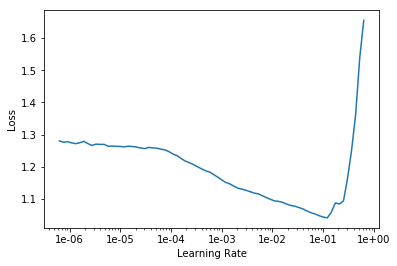

In [0]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(15, slice(1e-4, 3e-3))

epoch,train_loss,valid_loss,time
0,1.035309,1.137788,00:55
1,0.953097,0.614534,00:55
2,0.903790,0.792203,00:55
3,0.850425,44.291027,00:55
4,0.798585,0.480017,00:55
5,0.754791,0.767051,00:55
6,0.714642,0.459520,00:55
7,0.669859,0.398206,00:55
8,0.638115,0.504361,00:55
9,0.616247,0.383874,00:55


In [0]:
learn.save('a.40_volume-limited_resnet18-15ep')

(0.3, 0.8)

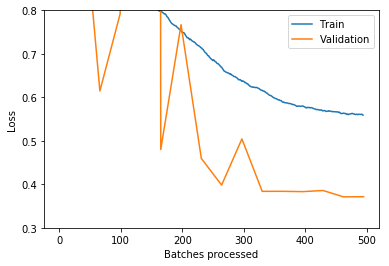

In [0]:
learn.recorder.plot_losses()
plt.ylim(0.3, 0.8)

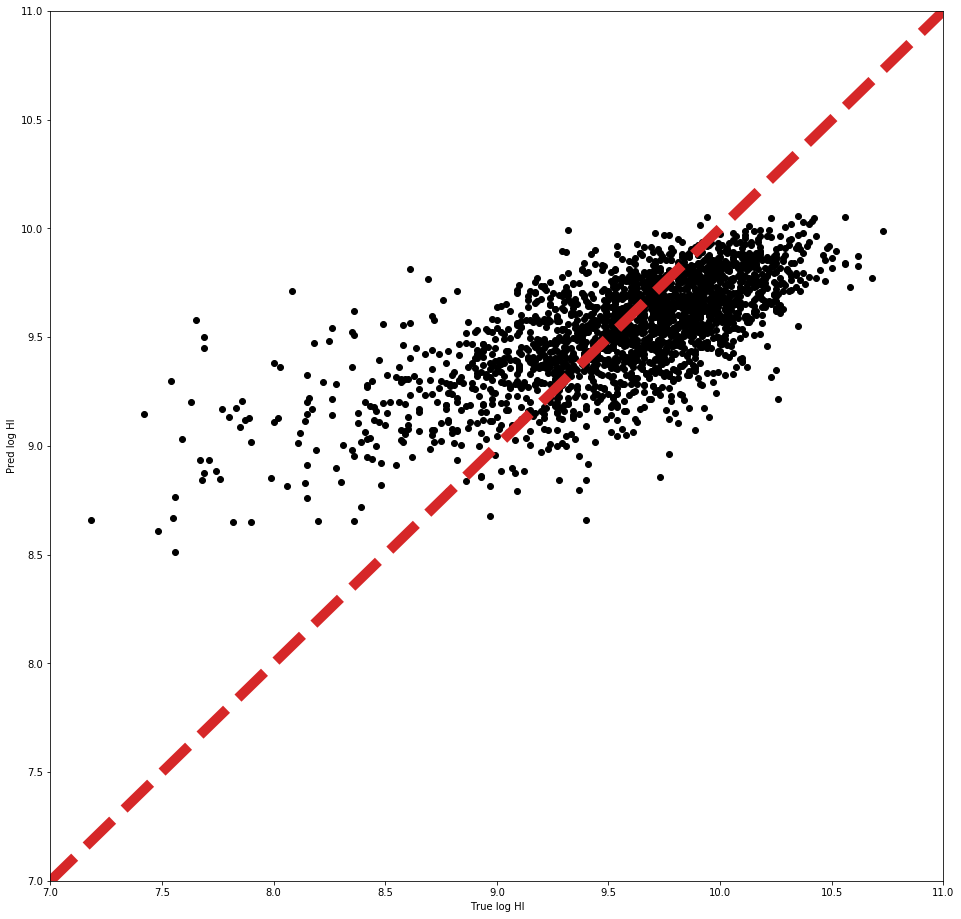

In [0]:
HI_pred, HI_true = learn.TTA()

# store results, along with AGC identifier, in new DataFrame
results = pd.DataFrame({'HI_true': HI_true.squeeze(), 'HI_pred': HI_pred.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)

plot_results(results, show_images=False)

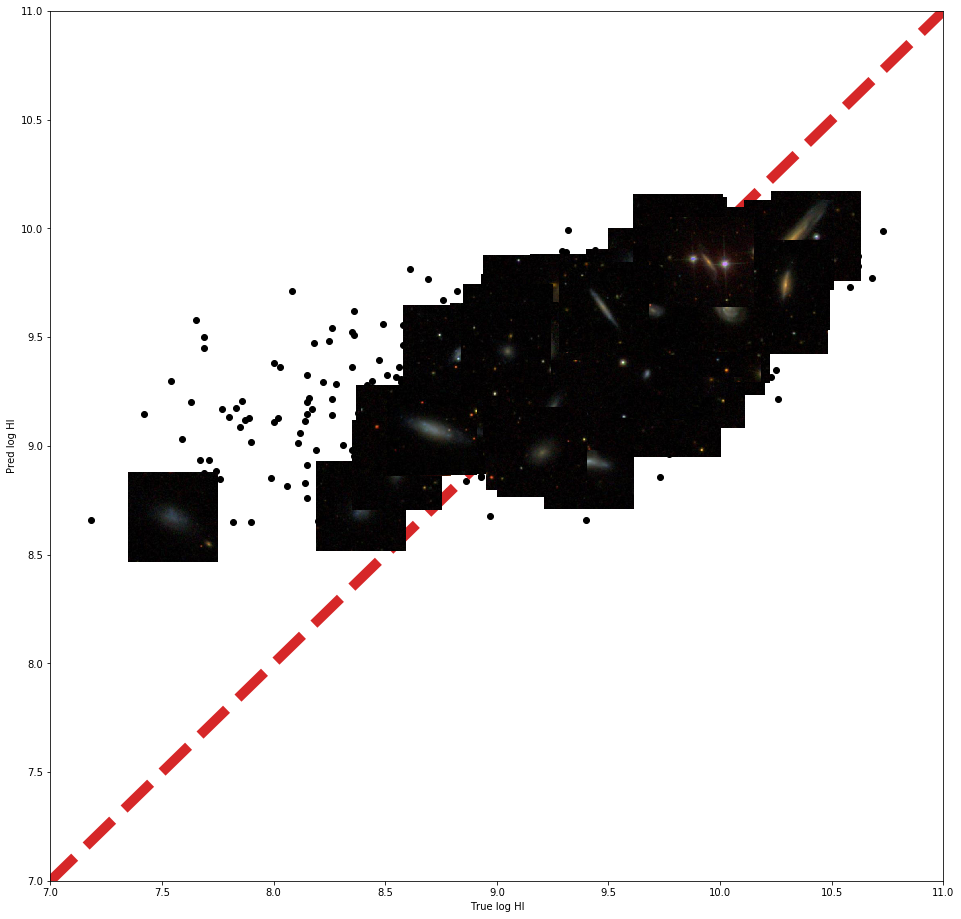

In [0]:
plot_results(results, show_images=True)


# Use crossmatched stellar masses in order to estimate gas fractions

In [0]:
df = pd.read_csv(f'{PATH}/data/a40.datafile3.csv')
display(df.sample(5))
display(df.shape)

,AGCNr,HIcode,OCcode,PhotoObjID,SpectObjID,rmodelmag,uminusr,z_sdss,z_err
669,120091,2,I,587724199359021099,1.206941e+17,14.11,1.54,0.02657,0.00011
3894,201196,2,I,587741602559623308,6.631046e+17,17.32,1.68,0.05391,0.00007
6295,224414,1,I,587734894365704336,3.464404e+17,16.88,1.54,0.01589,0.00053
3270,200233,1,I,587745540519755871,7.292529e+17,14.63,1.37,0.03254,0.00010
9771,733024,2,I,587739609177718904,6.017448e+17,16.55,1.57,0.05340,0.00008


(12468, 9)

In [0]:
df2 =  pd.read_csv(f'{PATH}/data/a40.datafile1.csv')
df2.rename(columns={'logMsun': 'logMHI'}, inplace=True)
display(df2.sample(5))
display(df2.shape)

,AGCNr,Name,RAdeg_HI,Decdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,errW50,HIflux,errflux,SNR,RMS,Dist,logMHI,HIcode,OCcode,NoteFlag
5370,202375,VIIIZ78,156.35625,10.61278,156.36501,10.61222,15992,62,11,0.67,0.05,6.5,2.07,233.4,9.93,2,I,*
3269,181756,NaN,126.73333,7.50306,126.72749,7.49806,9323,685,86,4.82,0.15,13.0,2.42,137.0,10.33,1,I,*
95,102558,NaN,1.76500,27.00917,1.76958,27.02444,2963,48,2,0.45,0.04,7.3,1.99,41.7,8.27,1,I,NaN
3749,190024,061-056,136.14125,13.15306,136.13249,13.16111,8169,80,8,0.55,0.05,5.9,2.32,120.9,9.28,2,I,NaN
13295,258139,NaN,234.67125,10.70056,234.66458,10.70194,12671,84,8,0.71,0.07,6.3,2.74,182.9,9.75,1,I,NaN


(15855, 18)

In [0]:
ids = np.array([os.path.basename(fn).strip('.jpg') for fn in glob(f'{PATH}/images-OC/*.jpg')], dtype=int)

a40 = df.join(df2.set_index('AGCNr'), on='AGCNr', rsuffix='_sdss')

a40 = a40[(a40.AGCNr.isin(ids)) & (a40.OCcode == 'I') & (a40.logMHI.notna())].copy()
display(a40.sample(5))
display(a40.shape)

,AGCNr,HIcode,OCcode,PhotoObjID,SpectObjID,rmodelmag,uminusr,z_sdss,z_err,Name,RAdeg_HI,Decdeg_HI,RAdeg_OC,DECdeg_OC,Vhelio,W50,errW50,HIflux,errflux,SNR,RMS,Dist,logMHI,HIcode_sdss,OCcode_sdss,NoteFlag
5614,210864,1,I,587734893826015411,3.455963e+17,15.45,1.74,0.02172,0.00020,068-080,178.07709,10.60000,178.07458,10.59750,6419,203,13,1.96,0.10,13.3,2.31,96.6,9.63,1,I,NaN
5225,210517,1,I,588017702927990865,4.525583e+17,15.30,1.35,0.03441,0.00008,068-010,174.22667,11.84500,174.23042,11.84805,10335,323,31,1.26,0.08,8.5,1.84,152.6,9.84,1,I,*
179,100202,1,I,587740586799399160,NaN,14.92,1.34,NaN,NaN,479-018,5.71458,24.14833,5.70833,24.15222,12528,239,69,1.15,0.09,7.8,2.13,174.2,9.91,1,I,*
5657,6875,1,I,588017723860779072,4.567817e+17,14.71,2.05,0.02033,0.00009,040-061,178.50542,6.34556,178.50374,6.34278,6107,290,9,3.96,0.10,22.2,2.34,92.3,9.90,1,I,NaN
5617,724147,1,I,587741726575951951,7.067336e+17,16.11,1.44,0.02242,0.00010,NaN,178.09583,25.08333,178.09500,25.08306,6753,183,25,1.18,0.08,8.3,2.35,100.8,9.45,1,I,NaN


(11731, 26)

In [0]:
sdss =  pd.read_csv(f'{PATH}/data/SDSS_basic_data.csv')
display(sdss.sample(5))
display(sdss.shape)

,objID,DR7ObjID,specObjID,ra,dec,z,zErr,velDisp,velDispErr,modelMag_u,modelMagErr_u,modelMag_g,modelMagErr_g,modelMag_r,modelMagErr_r,modelMag_i,modelMagErr_i,modelMag_z,modelMagErr_z,petroR50_r,petroR90_r,bptclass,oh_p16,oh_p50,oh_p84,lgm_tot_p16,lgm_tot_p50,lgm_tot_p84,sfr_tot_p16,sfr_tot_p50,sfr_tot_p84
45287,1237648721245241488,588848899927179425,341233460775512064,213.087554,-0.157688,0.080634,0.000007,34.43313,47.618200,19.10652,0.037416,18.00692,0.007942,17.59424,0.007958,17.28095,0.008876,17.16051,0.027953,2.163590,5.998427,1,8.854562,8.875150,8.920815,9.692334,9.753949,9.839166,0.028746,0.230915,0.489801
258258,1237662262698901663,587736541473996979,2022120421020690432,198.161196,8.904443,0.075441,0.000006,111.15570,19.860080,19.82451,0.056626,18.48294,0.008804,17.68505,0.006765,17.16609,0.006022,16.86861,0.013156,1.424146,3.333513,1,9.048502,9.065301,9.079789,10.233120,10.340910,10.442950,0.526548,0.661118,0.798020
98252,1237651190825025740,587725469600121052,508955168465774592,143.324666,57.599755,0.164788,0.000023,150.35320,12.353280,20.16436,0.077484,18.54903,0.010393,17.58146,0.007167,17.11394,0.006556,16.82281,0.016686,1.751355,5.591268,2,-9999.000000,-9999.000000,-9999.000000,10.805580,10.907730,11.007530,-0.857357,0.024090,0.471946
581477,1237671262278975690,587745541054070984,2909433181096667136,148.336739,14.880240,0.102695,0.000007,43.68756,20.998170,19.31664,0.037451,18.29316,0.008054,17.91000,0.007769,17.64655,0.009176,17.55090,0.023273,1.860498,3.545282,1,8.799033,8.814965,8.852765,9.691749,9.748405,9.838764,0.074448,0.251531,0.479832
493080,1237665350785106037,587739629560201370,2422945185735403520,227.755204,24.313820,0.034986,0.000013,63.36261,8.753632,17.99872,0.020227,16.64466,0.004162,16.00212,0.003539,15.62764,0.003887,15.35161,0.007422,3.295419,6.803774,1,8.965309,9.003378,9.052725,9.928852,10.015960,10.113350,-0.448452,-0.201145,0.092040


(717778, 31)

In [0]:
sdss.rename(columns={'lgm_tot_p50': 'logMstar'}, inplace=True)
sdss.drop_duplicates(subset='DR7ObjID', keep=False, inplace=True)         # for some reason there are ~10 duplicate IDs
sdss = sdss[(sdss.logMstar > 0) & (sdss.logMstar.notna())].copy()
sdss = sdss[['DR7ObjID', 'logMstar']].copy()

sdss.sample(5)

,DR7ObjID,logMstar
455355,587738195583303881,11.49143
273427,587736812598001931,10.09565
47049,588010359616700485,10.24768
281923,587732484343005365,11.28202
691721,587742062166999274,11.03962


In [0]:
# combine useful parts of both (AGCNr, DR7ObjID, M_HI, M_star)

a40.rename(columns={'PhotoObjID': 'DR7ObjID'}, inplace=True)
a40 = a40[['AGCNr', 'DR7ObjID', 'logMHI']].copy()

joined = a40.join(sdss.set_index('DR7ObjID'), on='DR7ObjID', how='left', rsuffix='_sdss')
joined = joined[joined.logMstar.notna()].copy()

display(joined.sample(5))
display(joined.shape)

,AGCNr,DR7ObjID,logMHI,logMstar
10892,252085,587742061629800754,8.75,7.852520
10743,714920,587736916757053499,9.88,9.997456
4841,214300,588010879291687094,9.85,9.558557
11021,251098,587736916758626580,9.99,10.168010
808,3956,587732054307963423,9.79,9.227369


(7411, 4)

In [0]:
(a40.DR7ObjID.duplicated()).sum()

0

In [0]:
(a40.DR7ObjID.isin(sdss.DR7ObjID)).sum(), len(a40)

(7411, 11731)

In [0]:
(sdss.DR7ObjID.isin(a40.DR7ObjID)).sum(), len(sdss)

(7411, 648000)

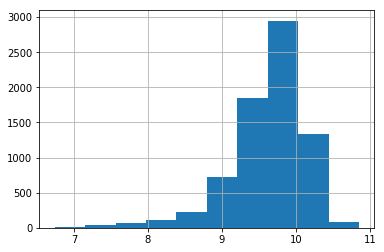

In [0]:
joined.logMHI.hist()

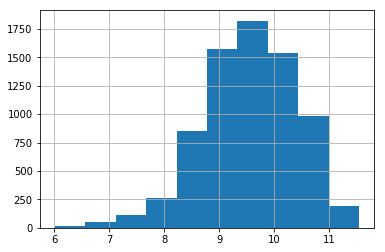

In [0]:
joined.logMstar.hist()

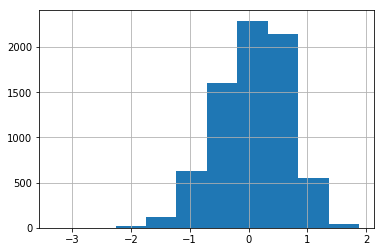

In [0]:
joined['logfgas'] = joined.logMHI - joined.logMstar
joined.logfgas.hist()

In [0]:
train_label_csv = f'{PATH}/data/a40-SDSS_gas-frac.csv'
joined[['AGCNr', 'logfgas']].to_csv(train_label_csv)

## Training on gas fractions

In [0]:
bs = 256
sz = 112

In [0]:
train_label_csv = f'{PATH}/data/a40-SDSS_gas-frac.csv'
df = pd.read_csv(train_label_csv)

src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2)
                .label_from_df(cols='logfgas',  label_cls=FloatList)
      )

data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize())

In [0]:
# load the trained model from before (trained on HI masses)
learn.data = data

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


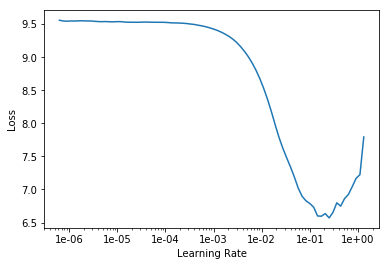

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(15, slice(3e-4, 3e-2))

epoch,train_loss,valid_loss,time
0,6.957683,3.642686,00:45
1,3.521134,0.510533,00:38
2,2.020876,0.364216,00:39
3,1.276536,0.833643,00:39
4,0.871242,0.316178,00:38
5,0.642079,0.417463,00:38
6,0.504416,0.368075,00:38
7,0.418922,0.307862,00:38
8,0.362902,0.304590,00:38
9,0.327281,0.304173,00:38


(0.2, 0.7)

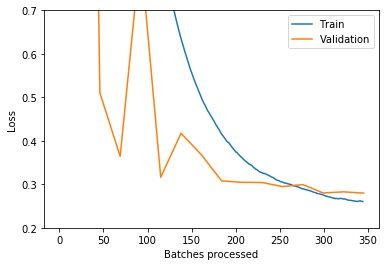

In [0]:
learn.recorder.plot_losses()
plt.ylim(0.2, 0.7)

In [0]:
learn.save('a.40_fgas_resnet18-15ep')

In [0]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def offset_image(objID, zoom=0.1):
    return OffsetImage(image2np(open_image(f'{PATH}/images-OC/{objID}.jpg').data), zoom=zoom)

def plot_results(results, show_images=True):
    fig, ax = plt.subplots(1, 1, figsize=(16, 16))
    ax.scatter('fgas_true', 'fgas_pred', data=results, c='black')

    if show_images:
        artists = []
        for objID, [Z_true, Z_pred] in results.sample(100).iterrows():
            ab = AnnotationBbox(offset_image(objID, zoom=0.4), (Z_true, Z_pred), xycoords='data', frameon=False)
            artists.append(ax.add_artist(ab))
            
    # plot 1:1 line
    plt.plot([-4, 4], [-4, 4], c='C3', ls='--', lw='10')

    ax.set_xlim(-2, 1.5)
    ax.set_ylim(-2, 1.5)
    ax.set_xlabel(r'True log $\mu_{\rm gas}$')
    ax.set_ylabel(r'Pred log $\mu_{\rm gas}$')



In [0]:
fgas_pred, fgas_true = learn.TTA()

# store results, along with AGC identifier, in new DataFrame
results = pd.DataFrame({'fgas_true': fgas_true.squeeze(), 'fgas_pred': fgas_pred.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)

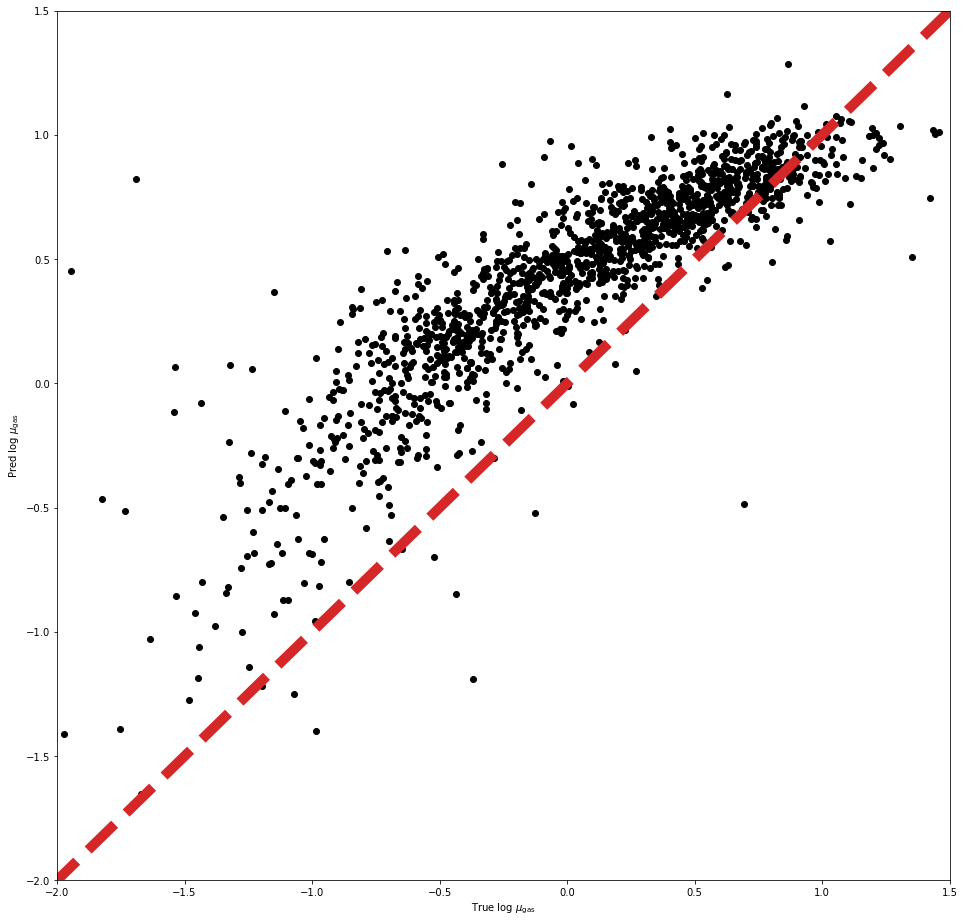

In [0]:
plot_results(results, show_images=False)

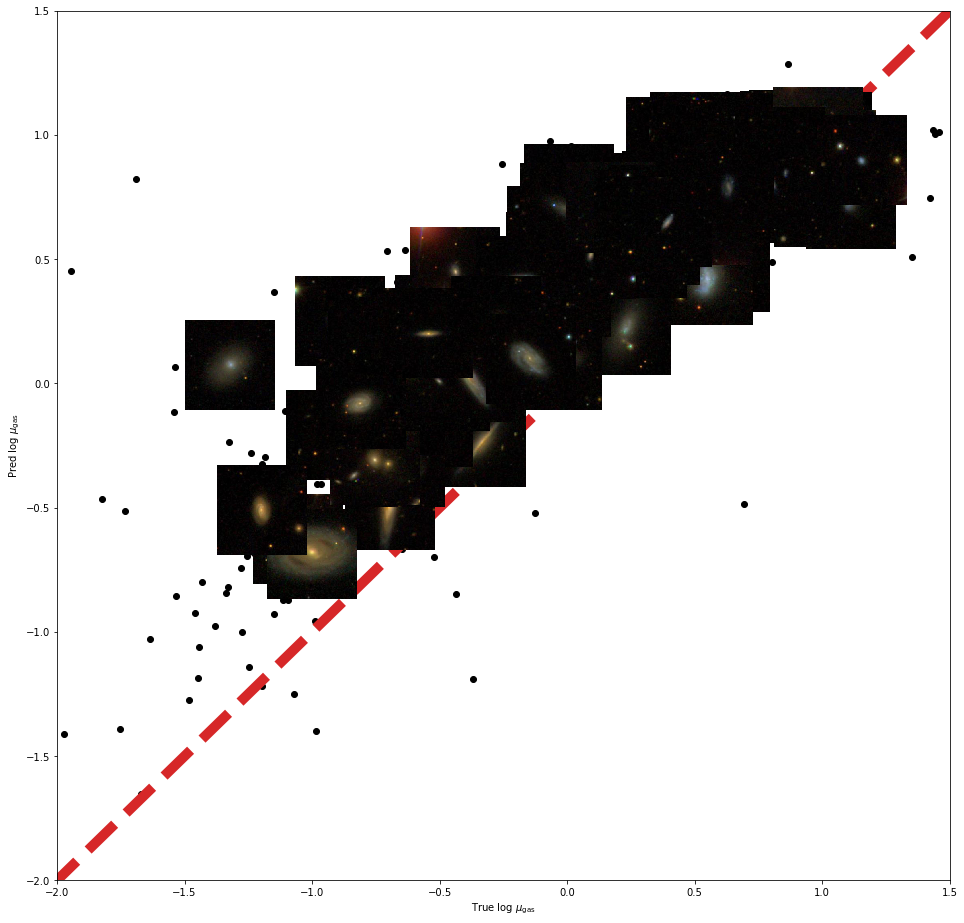

In [0]:
plot_results(results, show_images=True)

## Continue training with full-sized images

In [0]:
bs = 256
sz = 224

df = pd.read_csv(train_label_csv)

src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2)
                .label_from_df(cols='logfgas',  label_cls=FloatList)
      )

data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize())

In [0]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


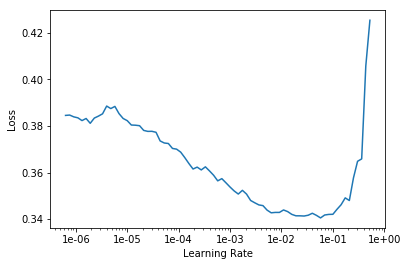

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(15, slice(3e-5, 3e-3))

epoch,train_loss,valid_loss,time
0,0.372497,0.361189,00:53
1,0.337733,0.297560,00:51
2,0.312941,0.281470,00:51
3,0.296159,0.347520,00:52
4,0.287251,0.265775,00:51
5,0.282160,0.270025,00:52
6,0.277732,0.259170,00:51
7,0.273976,0.255223,00:51
8,0.270723,0.262450,00:51
9,0.266498,0.257443,00:51


(0.2, 0.4)

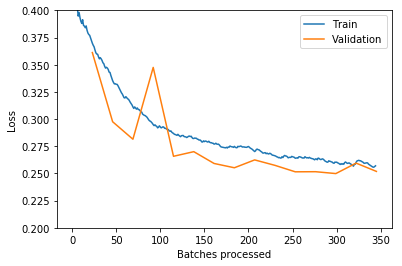

In [0]:
learn.recorder.plot_losses()
plt.ylim(0.2, 0.4)

In [0]:
learn.save('a.40_fgas_resnet18-15ep_continued')

# Train a resnet 34

In [0]:
learn = cnn_learner(data, base_arch=models.resnet34, pretrained=True, loss_func=root_mean_squared_error)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


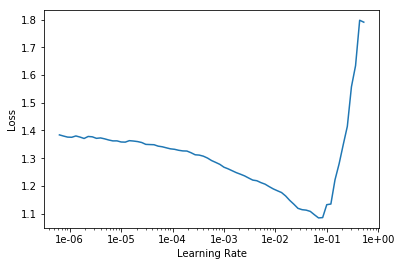

In [0]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(40, slice(3e-5, 3e-3))

epoch,train_loss,valid_loss,time
0,1.206951,0.646118,00:53
1,1.124741,0.599098,00:53
2,1.058533,0.568798,00:53
3,0.978934,0.517640,00:54
4,0.883492,0.425218,00:54
5,0.766409,0.368235,00:53
6,0.643666,0.329978,00:53
7,0.531953,0.304472,00:53
8,0.449928,0.301889,00:53
9,0.391787,0.286096,00:54


(0.15, 0.4)

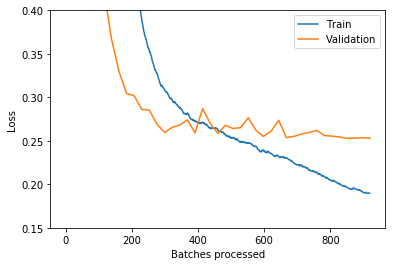

In [0]:
learn.recorder.plot_losses()
plt.ylim(0.15, 0.4)

In [0]:
learn.save('a.40_fgas_resnet34-40ep')

# Try trained resnet-50

In [0]:
bs = 128
sz = 224

df = pd.read_csv(train_label_csv)

src = (ImageList.from_df(df, path=PATH, folder='images-OC', suffix='.jpg', cols='AGCNr')
                .split_by_rand_pct(0.2)
                .label_from_df(cols='logfgas',  label_cls=FloatList)
      )

data = (src.transform(get_transforms(do_flip=True, flip_vert=True, max_lighting=0, max_warp=0), size=sz)
            .databunch(bs=bs)
            .normalize())

In [0]:
learn = cnn_learner(data, base_arch=models.resnet50, pretrained=True, loss_func=root_mean_squared_error)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:04<00:00, 22590493.15it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


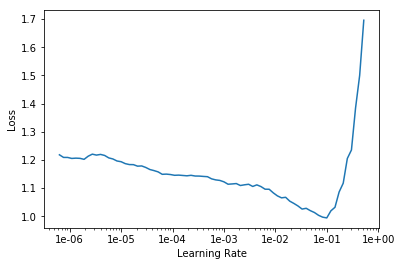

In [0]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(100, slice(1e-4, 5e-3))

epoch,train_loss,valid_loss,time
0,1.007483,0.647169,01:12
1,0.925515,0.564893,01:09
2,0.855149,0.525284,01:09
3,0.767391,0.549434,01:09
4,0.682560,0.417958,01:09
5,0.582287,0.395401,01:09
6,0.500132,0.366233,01:09
7,0.434138,0.324835,01:09
8,0.378052,0.298241,01:09
9,0.332916,0.314249,01:09


(0.15, 0.4)

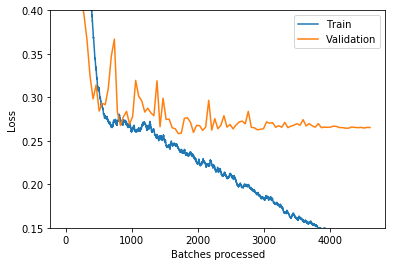

In [62]:
learn.recorder.plot_losses()
plt.ylim(0.15, 0.4)

In [0]:
learn.save('a.40_fgas_resnet50-100ep')

#  Plot results

In [64]:
fgas_pred, fgas_true = learn.TTA()

# store results, along with AGC identifier, in new DataFrame
results = pd.DataFrame({'fgas_true': fgas_true.squeeze(), 'fgas_pred': fgas_pred.squeeze()})
results['AGCNr'] = np.array([os.path.basename(fn).strip('.jpg') for fn in data.valid_ds.items])
results.set_index('AGCNr', drop=True, inplace=True)

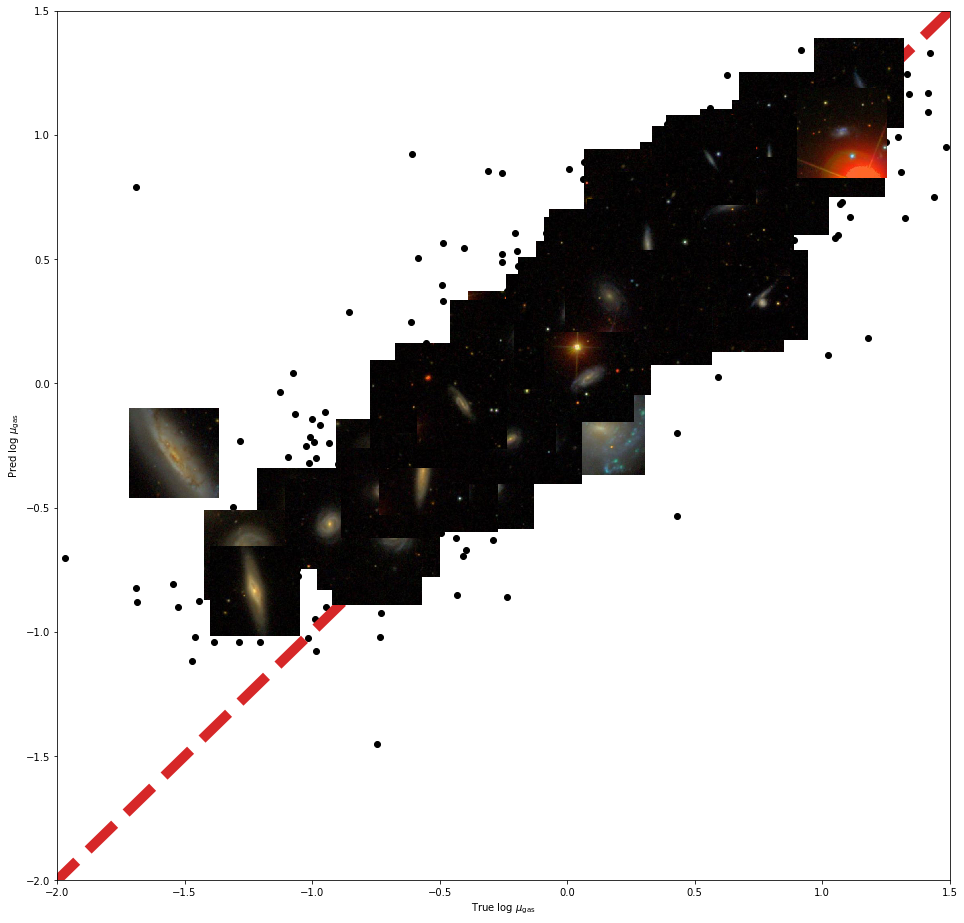

In [65]:
plot_results(results, show_images=True)

In [66]:
!pip install corner

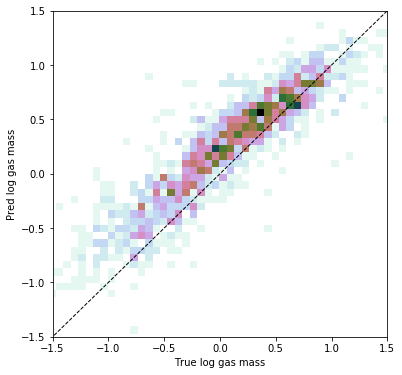

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.hist2d(results.fgas_true, results.fgas_pred, bins=60, range=[(-2, 2), (-2, 2)], cmap=plt.cm.cubehelix_r);
ax.plot([-4, 4], [-4, 4], c='k', ls='--', lw='1')

ax.set_xlabel('True log gas mass')
ax.set_ylabel('Pred log gas mass')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5);

In [102]:
root_mean_squared_error(fgas_true, fgas_pred)

tensor(0.3381)

Note that this is equal to the amount of scatter in the HI mass (true/pred) comparison as well, since we would just be adding the log stellar mass (with zero scatter) to both quantities.